# TPAD Takeoff performance





In [1]:
import os#.path as pth
import openmdao.api as om
from fastoad import api
import logging
import shutil
import time
import warnings
warnings.simplefilter(action='ignore')
pth =os.path
from fastoad.io import VariableIO
import sys
sys.path.append('C:\\Users\\vinx0\\OneDrive\\Desktop\RHEA\\rhea')
sys.path.append('C:\\Users\\vinx0\\OneDrive\\Desktop\RHEA')
from Add_functions import generate_configuration_file
from fastoad.io import VariableIO
import pandas as pd
from rhea.utils.postprocessing.analysis_and_plots_RHEA import wing_geometry_plot, \
drag_polar_plot, mass_breakdown_sun_plot,mass_breakdown_bar_plot, aircraft_geometry_plot,payload_range_plot,plot_double,drag_breakdown_sun_plot,drag_breakdown_bar_plot,loading_diagram_plot
from scipy import constants
from fastoad.utils.postprocessing import VariableViewer
import matplotlib.pyplot as plt


Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


# RHEA CALCULATION

In [2]:

WORK_FOLDER_PATH = 'workdir'
results_folder = 'TPAD_baseline_ref_ML_L1' 
#os.mkdir(WORK_FOLDER_PATH+'/'+results_folder+'/TO')
SIZING_FOLDER_PATH = WORK_FOLDER_PATH+'/'+results_folder +'/'+'sizing' 
DOC_FOLDER_PATH = WORK_FOLDER_PATH +'/'+results_folder +'/'+'DOC'
TO_FOLDER_PATH = WORK_FOLDER_PATH +'/'+results_folder +'/'+'TO'

CONFIGURATION_FILE = generate_configuration_file(TO_FOLDER_PATH, pth.join('workdir', 'TPAD_takeoff.toml')) 
SOURCE_FILE = pth.join(SIZING_FOLDER_PATH, 'problem_outputs.xml') 


logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')
logging.getLogger('fastoad.module_management.bundle_loader').setLevel(logging.WARNING)

In [3]:
data=VariableIO(SOURCE_FILE).read() 
data["data:weight:aircraft:MTOW"].value          = 23572.
#data["data:mission:sizing:takeoff:V_MCA"].value       = 49.9 #49.9 #49.9
data["data:propulsion:RTO_power"].value          = 2001582.729865489

VariableIO(SOURCE_FILE).write(data)  


In [4]:
api.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)
eval_problem = api.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Problem inputs written in C:\Users\vinx0\OneDrive\Desktop\RHEA\workdir\TPAD_baseline_ref_ML_L1\TO\problem_inputs.xml


-------------------------------------------
-------------------------------------------
-------------------------------------------
-------------------------------------------
-------------------------------------------
-------------------------------------------
speeds found
TODn =  1051.1025588112198 1.15*TODn =  1208.7679426329025
VR =  58.7245
TODn-1 =  1356.3736924871089
ASDn-1 =  1356.5931710899067
V1 =  59.29198028746006 V_EF =  [58.64552665]
ASD =  1351.3412551034703
TODn-1 =  1384.2480358129615
ASDn-1 =  1325.2893132437248
ASD =  1319.08519341237
V1>VR
1384.2480358129615
NL: NLBGSSolver 'NL: NLBGS' on system '': residuals contain 'inf' or 'NaN' after 1 iterations.


INFO    : Computation finished after 323.87 seconds
INFO    : Problem outputs written in C:\Users\vinx0\OneDrive\Desktop\RHEA\workdir\TPAD_baseline_ref_ML_L1\TO\problem_outputs.xml


1384.0


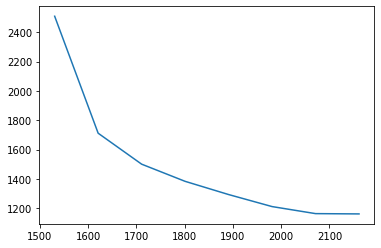

In [28]:
import numpy as np
SHP_TOs=np.array([0.85,0.9,0.95,1,1.05,1.1,1.15,1.2])*1801
TOFLs=[ 2509,1712,1501,1384,1294,1212,1164,1162]
plt.plot(SHP_TOs,TOFLs)

from scipy import interpolate

f = interpolate.interp1d(SHP_TOs, TOFLs,kind='linear',fill_value="extrapolate")
x= 1801
y=f(x)
print(y)

TOFL 1384 m
TODn-1 1384 m V_1 58.7  V_EF 58.1


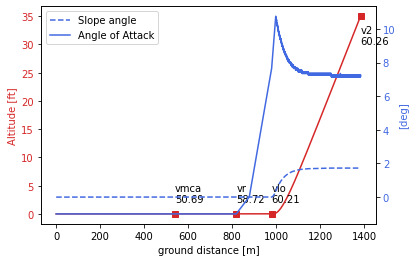

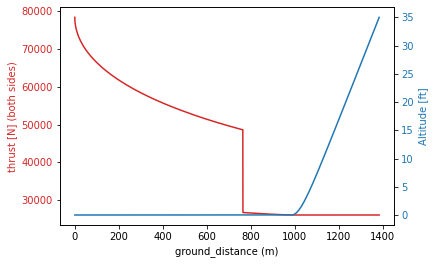

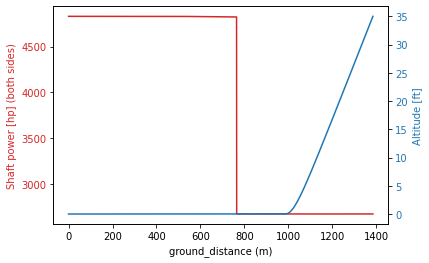

53.2245 55.759
78374.46983760282 1828.4142909916516


In [5]:
flight_data_to= pd.read_csv(pth.join(TO_FOLDER_PATH,'TO_flight_points.csv' ))
RESULT_FILE = pth.join(TO_FOLDER_PATH,'problem_outputs.xml' )

flight_data_to= flight_data_to[flight_data_to.name=="take off"]
vv = VariableViewer()
#vv.display()
vv.load(RESULT_FILE)
results=vv.get_variables()
V_1=results["data:mission:sizing:takeoff:V_1"].value
V_EF=results["data:mission:sizing:takeoff:V_EF"].value
V_2=results["data:mission:sizing:takeoff:V_2"].value
V_liftoff=results["data:mission:sizing:takeoff:V_liftoff"].value
V_rotate=results["data:mission:sizing:takeoff:V_rotate"].value
V_MCA=results["data:mission:sizing:takeoff:V_MCA"].value
TOFL=results["data:mission:sizing:takeoff:TOFL"].value
print('TOFL',round(TOFL),'m')
print('TODn-1',round(float(flight_data_to.ground_distance.values[-1])),'m', 'V_1',round(float(V_1),1),' V_EF',round(float(V_EF),1))

fp_v2 = flight_data_to.iloc[-1]
fp_vlo = flight_data_to[flight_data_to.true_airspeed>=V_liftoff].iloc[0]
fp_vr = flight_data_to[flight_data_to.true_airspeed>=V_rotate].iloc[0]
fp_vmca = flight_data_to[flight_data_to.true_airspeed>=V_MCA].iloc[0]

color = 'tab:red'

fig, ax1 = plt.subplots()
ax1.set_xlabel('ground distance [m]')
ax1.set_ylabel('Altitude [ft]', color=color)
ax1.plot(flight_data_to.ground_distance, flight_data_to.altitude/constants.foot,
          [fp_v2.ground_distance,fp_vlo.ground_distance,fp_vr.ground_distance,fp_vmca.ground_distance],
          [fp_v2.altitude/constants.foot,fp_vlo.altitude/constants.foot,fp_vr.altitude/constants.foot,fp_vmca.altitude/constants.foot],'bs',color=color)
ax1.text(fp_v2.ground_distance,fp_v2.altitude/constants.foot,'v2\n'+ str(round(V_2,2))).set_y(30)
ax1.text(fp_vlo.ground_distance,fp_vlo.altitude/constants.foot,'vlo\n'+ str(round(V_liftoff,2))).set_y(2)
ax1.text(fp_vr.ground_distance,fp_vr.altitude/constants.foot,'vr\n'+ str(round(V_rotate,2))).set_y(2)
ax1.text(fp_vmca.ground_distance,fp_vmca.altitude/constants.foot,'vmca\n'+ str(round(V_MCA,2))).set_y(2)

ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.tick_params(axis='y', labelcolor='royalblue')
ax2.set_ylabel('[deg]', color='royalblue')
ax2.plot(flight_data_to.ground_distance, flight_data_to.slope_angle/constants.degree,'--',color='royalblue',label='Slope angle')
ax2.plot(flight_data_to.ground_distance, flight_data_to.alpha/constants.degree,color='royalblue',label='Angle of Attack')
ax2.legend(loc='upper left')

plot_double(flight_data_to.ground_distance,flight_data_to.thrust,flight_data_to.altitude/constants.foot,'ground_distance (m)','thrust [N] (both sides)','Altitude [ft]')
plot_double(flight_data_to.ground_distance,flight_data_to.TPshaft_power/constants.hp,flight_data_to.altitude/constants.foot,'ground_distance (m)','Shaft power [hp] (both sides)','Altitude [ft]')
#plot_double(flight_data_to.time,flight_data_to.thrust,flight_data_to.altitude/constants.foot,'time (s)','thrust [N] (both sides)','Altitude [ft]')
#plot_double(flight_data_to.time,flight_data_to.alpha/constants.degree,flight_data_to.slope_angle/constants.degree,'time (s)','alpha [deg] ','gamma [deg]')
#plot_double(flight_data_to.ground_distance,flight_data_to.alpha/constants.degree,flight_data_to.altitude/constants.foot,'distance (m)','alpha [deg] ','gamma [deg]')
print(1.05*V_MCA,1.1*V_MCA)
flight_data_to.TPshaft_power.iloc[0]/constants.hp
print(flight_data_to.thrust.iloc[0],
flight_data_to.TP_residual_thrust.iloc[0])

TOD 1051 m 1.15xTOD 1209 m


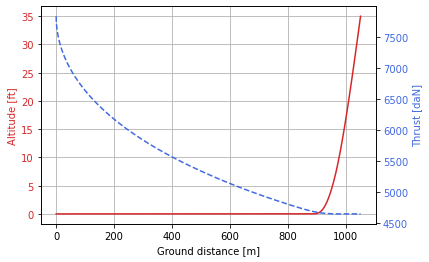

In [9]:
flight_data_to= pd.read_csv(pth.join(TO_FOLDER_PATH,'TO_flight_points.csv' ))
flight_data_to= flight_data_to[flight_data_to.name=="TOD"]


TOD = flight_data_to.ground_distance.values[-1]
print('TOD',round(float(TOD)),'m', '1.15xTOD',round(float(1.15*TOD)),'m')
fig, ax1 = plt.subplots()
plt.grid()

ax1.set_xlabel('Ground distance [m]')
ax1.set_ylabel('Altitude [ft]', color='tab:red')
ax1.plot(flight_data_to.ground_distance, flight_data_to.altitude/constants.foot ,'-',color='tab:red')#,label='Altitude')
#ax1.plot(df[df.FL==20000].RTO, 785.9*np.ones(len(df[df.FL==20000].RTO.values)) ,'_-',color='red',label='ATR72_baseline')

#ax3=ax1.twinx()
#ax3.spines['right'].set_position(("axes", 1.2))
#ax3.tick_params(axis='y', labelcolor='red')
#ax3.set_ylim(2500,5000)
#ax3.set_ylabel('Shaft power [hp] (both sides)', color='red')
#ax3.plot(flight_data_to.ground_distance, flight_data_to.TPshaft_power/constants.hp  ,'--',color='red')#,label='FL180')

ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.tick_params(axis='y', labelcolor='royalblue')

ax2.set_ylabel('Thrust [daN]', color='royalblue')
ax2.plot(flight_data_to.ground_distance, flight_data_to.thrust/10 ,'--',color='royalblue')#,label='FL180')

#ax2.legend(loc='upper right')